# How To: Analyze and Plot Three Point Shooting Trends
This tutorial goes through the process of generating figures in my [Three Point Shooting Trends blog](https://blog.sradjoker.cc/posts/nba-3pt-winning/). Please read the blog first before continuing on to the tutorial.
In this tutorial you will learn the following:
1. Scrape league average stats for several seasons using `nba_api`.
2. Plot using `plotnine` which is a Python port of `R`'s `ggplot`. This package is how I generate most of my visualizations.
3. Saving data in different formats including: `csv`, `parquet` & `feather`. We'll go through pros and cons of each.
4. Processing data using `pandas`

First, let's start by loading the basic packages required for this tutorial.

In [1]:
import pandas as pd  # for processing data
import numpy as np  # for numerical operations on arrays
from tqdm import tqdm  # gives up progress bar

# don't raise warnings when chaining pandas operations
pd.options.mode.chained_assignment = None

data_DIR = "./data/"

## Plotting Basic 3 PT Year to Year Trends

### Scraping the Data

Now, let's load the function required for scraping league average data.

In [2]:
from nba_api.stats.endpoints import leaguedashteamstats

In [3]:
year = 2023
# the function requires season to be in the form "2023-24" instead of "2024"
season = str(year) + "-" + str(year + 1)[-2:]
# Get per game stats for a regular season
stats = leaguedashteamstats.LeagueDashTeamStats(per_mode_detailed="PerGame", season_type_all_star="Regular Season", season = season)
# Get data frames
df = stats.get_data_frames()[0]
# We don't need all columns, so we load only a subset 
df = df[["TEAM_NAME","W","L","W_PCT","FG3M","FG3A","FG3_PCT"]]
df.head(2)

,TEAM_NAME,W,L,W_PCT,FG3M,FG3A,FG3_PCT
0,Atlanta Hawks,20,27,0.426,13.6,37.7,0.361
1,Boston Celtics,37,11,0.771,16.2,42.6,0.380


In [4]:
# Sum all the columns and append sum as a new row
df.loc["Total"] = df.sum()
df.tail(1)

,TEAM_NAME,W,L,W_PCT,FG3M,FG3A,FG3_PCT
Total,Atlanta HawksBoston CelticsBrooklyn NetsCharlo...,701,701,14.981,384.6,1049.6,10.997


In [5]:
# Average the makes and attempts for 30 teams
df.loc["Total","FG3M"] = df.loc["Total","FG3M"]/30
df.loc["Total","FG3A"] = df.loc["Total","FG3A"]/30 
# Get the percentage by dividing makes column with attempts column
df.loc["Total","FG3_PCT"] = df.loc["Total","FG3M"]/df.loc["Total","FG3A"]
# Rename the team_name column entry of total row to the season
df.loc["Total","TEAM_NAME"] = year +1
# round the columns to three decimals
df.iloc[:,4:] = df.iloc[:,4:].round(3)
# get only the last row i.e. the total row
dft = df.tail(1)
dft = dft[["TEAM_NAME","FG3M", "FG3A", "FG3_PCT"]]
dft

,TEAM_NAME,FG3M,FG3A,FG3_PCT
Total,2024,12.82,34.987,0.366


Now let's run the above code for the past 10 seasons

In [6]:
dfa = []
for year in tqdm(range(2014,2024)):
    # the function requires season to be in the form "2023-24" instead of "2024"
    season = str(year) + "-" + str(year + 1)[-2:]
    # Get per game stats for a regular season
    stats = leaguedashteamstats.LeagueDashTeamStats(per_mode_detailed="PerGame", season_type_all_star="Regular Season", season = season)
    # Get data frames
    df = stats.get_data_frames()[0]
    # We don't need all columns, so we load only a subset 
    df = df[["TEAM_NAME","W","L","W_PCT","FG3M","FG3A","FG3_PCT"]]
    
    df.loc["Total"] = df.sum()
    df.loc["Total","FG3M"] = df.loc["Total","FG3M"]/30
    df.loc["Total","FG3A"] = df.loc["Total","FG3A"]/30 
    df.loc["Total","FG3_PCT"] = df.loc["Total","FG3M"]/df.loc["Total","FG3A"]
    df.loc["Total","TEAM_NAME"] = year +1
    df.iloc[:,4:] = df.iloc[:,4:].round(3)
    dft = df.tail(1)
    dft = dft[["TEAM_NAME","FG3M", "FG3A", "FG3_PCT"]]
    dfa.append(dft)
df_3pct = pd.concat(dfa)

100%|██████████| 10/10 [00:08<00:00,  1.12it/s]


In [7]:
# rebane team name column to season
df_3pct = df_3pct.rename(columns={"TEAM_NAME":"Season"}).reset_index(drop=True)
df_3pct

,Season,FG3M,FG3A,FG3_PCT
0,2015,7.850,22.410,0.350
1,2016,8.507,24.083,0.353
2,2017,9.650,27.003,0.357
3,2018,10.487,28.997,0.362
4,2019,11.360,32.007,0.355
5,2020,12.193,34.103,0.358
6,2021,12.707,34.637,0.367
7,2022,12.440,35.180,0.354
8,2023,12.340,34.207,0.361
9,2024,12.820,34.987,0.366


### Plotting the Data using Plotnine
Now that we have the data, let's plot it. We'll do it using `plotnine` package. I recommend reading the [documentation](https://plotnine.readthedocs.io/) and going through the tutorials there.  
Let's load the modules from plotnine, we'll use in plotting:

In [8]:
from plotnine import ggplot, aes, geom_line, geom_point, labs

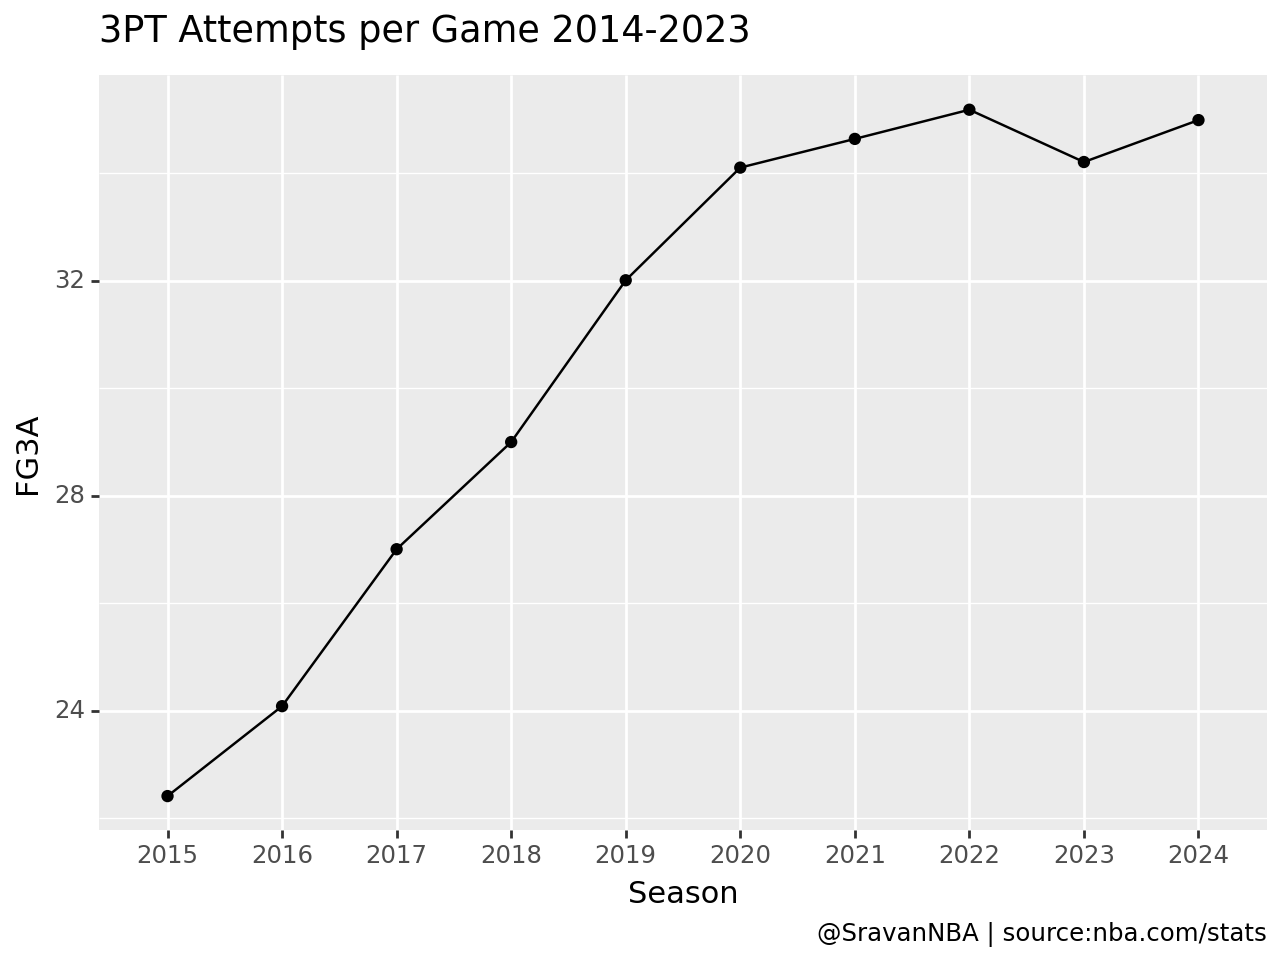

In [9]:
p = (
    # load the dataframe here
    ggplot(df_3pct)
    # define the x and y data i.e. aesthetics
    + aes(x="Season", y= "FG3A")
    # line plot
    + geom_line(group=1)
    # scatter plot
    + geom_point()
    # Set title and caption
    + labs(
            title= "3PT Attempts per Game 2014-2023",
            caption="@SravanNBA | source:nba.com/stats",
        )
)
# draw the plot
p.draw()

Wow, that was easy. The default plot here is much better formatted compared to a default `matplotlib` plot. This is what makes using `plotnine` fun and easy. We need to just worry about the data and then plotnine takes care about the formatting.  
Now, lets make the plot even better looking by adding a theme. We need to import some things again from `plotnine`

In [10]:
from plotnine import themes, theme, element_text

We are going to be using the `xkcd` theme. For a list of available themes refer to `plotnine` [themes documentation](https://plotnine.readthedocs.io/en/stable/api.html#themes). Let's define the theme now: 

In [11]:
theme_idv = themes.theme_xkcd(base_size=11)

I want to slightly modify the theme by making the title bold and increase the title font size to `16`. That can be done by updating the theme like so:

In [12]:
theme_idv += theme(
    plot_title=element_text(face="bold", size=16),
)

Now, we add the theme to the previous plot by just adding this line to the code `+ theme_idv`

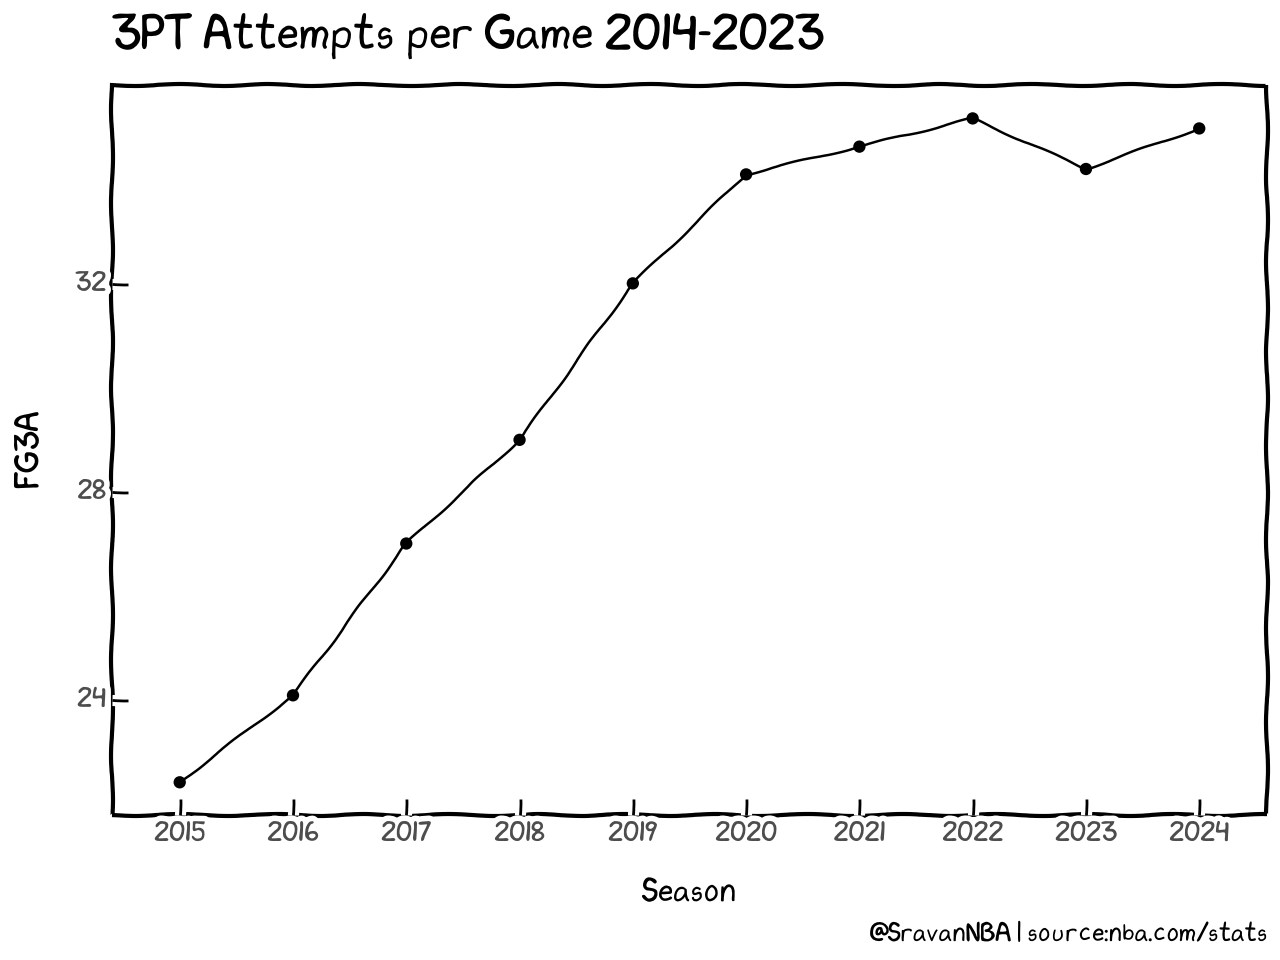

In [13]:
p = (
    ggplot(df_3pct)
    + aes(x="Season", y= "FG3A")
    + geom_line(group=1)
    + geom_point()
    + labs(
            title= "3PT Attempts per Game 2014-2023",
            caption="@SravanNBA | source:nba.com/stats",
        )
    # adding the new theme
    + theme_idv
)
p.draw()

Wasn't that easy? Now the graph with xkcd looks much better than the vanilla theme we saw before. Similarly we can generate plot for 3PT Makes by just changing `y="FGM"` in the code. For generating 3PT percentage trends, we set `y="FG3_PCT"`. Once you start getting used to `plotnine`, visualizing data will become much easier. 

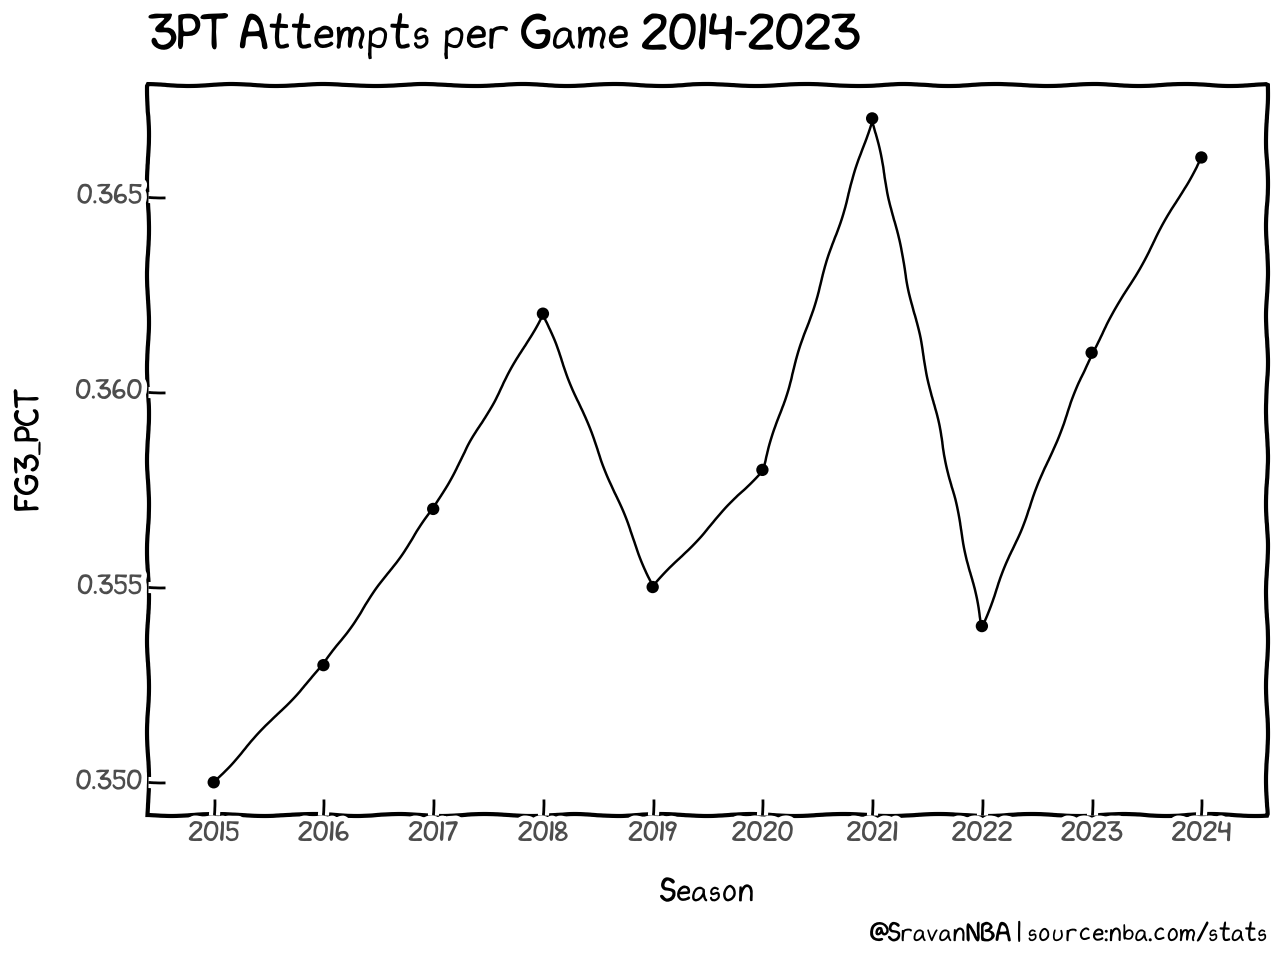

In [14]:
p = (
    ggplot(df_3pct)
    # we change the y aesthetic here
    + aes(x="Season", y= "FG3_PCT")
    + geom_line(group=1)
    + geom_point()
    + labs(
            title= "3PT Attempts per Game 2014-2023",
            caption="@SravanNBA | source:nba.com/stats",
        )
    + theme_idv
)
p.draw()

## 3FG% vs Wins Year to Year when Team 3P% > Opponent 3P% + 5%

### Scraping Data and saving them in different file formats
Now, let's load the function required for boxscores, which are required to get individual game 3FG% and whether a team has won or not

In [15]:
from nba_api.stats.endpoints import leaguegamelog

In [16]:
season = "2022"
# api call for getting the data
stats = leaguegamelog.LeagueGameLog(
    player_or_team_abbreviation="T",
    season=season,
    season_type_all_star="Regular Season",
)
df = stats.get_data_frames()[0]
# define the file name string
file_name = data_DIR + "NBA_BoxScores_" + "Standard" + "_" + season 

`pandas` offers us [several ways](https://pandas.pydata.org/docs/reference/frame.html#serialization-io-conversion) of saving dataframes. The most commonly used one is `to_csv()` which saves the data in a `csv` format. `csv`
I want to introduce you to other formats of storing data including `parquet` and `feather`.

In [17]:
df.to_csv(file_name + ".csv")
df.to_parquet(file_name + ".parquet")
df.to_feather(file_name + ".feather")

New, let's try to evaluate how long it takes to save the file by using `timeit` magic function. Read more about jupyter/IPython built-in magic commands [here](https://ipython.readthedocs.io/en/stable/interactive/magics.html).

In [18]:
%%timeit
df.to_csv(file_name + ".csv")

27.5 ms ± 3.82 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
%%timeit
df.to_parquet(file_name + ".parquet")

19 ms ± 2.06 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
%%timeit
df.to_feather(file_name + ".feather")

6.23 ms ± 376 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Time taken to save: `feather` <`parquet` < `csv`  
Let's look at the file sizes

In [21]:
import os

In [22]:
file_stats = os.stat(file_name + ".csv")
file_size = file_stats.st_size >> 10
print(f"{file_size} kB")

355 kB


In [23]:
file_stats = os.stat(file_name + ".parquet")
file_size = file_stats.st_size >> 10
print(f"{file_size} kB")

88 kB


In [24]:
file_stats = os.stat(file_name + ".feather")
file_size = file_stats.st_size >> 10
print(f"{file_size} kB")

256 kB


So,File size: `parquet` < `feather` < `csv`  

I personally use `parquet` files over `csv` for the below reasons:

### Parquet Files
- why not csv
  - not compressed, can take too much space
  - doesn't save `dtypes`, pandas has to infer `dtypes` after reading the `csv`. It isn't reliable and sometimes you have to set `dtypes` manually
- What is parquet
> Apache Parquet is an open source, column-oriented data file format designed for efficient data storage and retrieval. It provides efficient data compression and encoding schemes with enhanced performance to handle complex data in bulk.
- why parquet
  - compressed automatically
  - saves dtypes
  - faster to write and load
- disadvantages
  - you can't read the file visually, like you can a `csv`
  - No proper/popular GUI tool to visualize `csv` files like Microsoft Excel or Google Sheets


Now let's back to scraping the data:  
First we save the data in `parquet` format for all 10 seasons

In [25]:
season_start = 2014
season_end = 2024
seasons = np.arange(season_start, season_end, 1).astype(str)
for season in tqdm(seasons):
    stats = leaguegamelog.LeagueGameLog(
        player_or_team_abbreviation="T",
        season=season,
        season_type_all_star="Regular Season",
    )
    df = stats.get_data_frames()[0]
    df.to_parquet(data_DIR + "NBA_BoxScores_" + "Standard" + "_" + season + ".parquet")

100%|██████████| 10/10 [00:08<00:00,  1.12it/s]


### Processing Data
Let's load data for a season

In [26]:
year = 2023
df = pd.read_parquet(data_DIR + f"NBA_BoxScores_Standard_{year}.parquet")
df.head(2)

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE
0,22023,1610612747,LAL,Los Angeles Lakers,0022300061,2023-10-24,LAL @ DEN,L,240,41,...,31,44,23,5,4,12,18,107,-12,1
1,22023,1610612743,DEN,Denver Nuggets,0022300061,2023-10-24,DEN vs. LAL,W,240,48,...,33,42,29,9,6,12,15,119,12,1


Each row, only has that team's data but we need both teams data in a single row to compare 3PT shooting between two teams.
To have data for both teams in the same row, we follow same steps as in the [previous tutorial](https://github.com/sravanpannala/NBA-Tutorials/blob/main/sos_adjusted_ratings/how_to_adjust_nba_team_ratings_for_sos.ipynb).

In [27]:
df = df[["GAME_ID","TEAM_NAME","FG3A","FG3M","FG3_PCT","PLUS_MINUS"]]
df1 = df.groupby("GAME_ID")
df1_1 = df1.nth(0)
df1_2 = df1.nth(1)
df1_1.columns = ["GAME_ID"] + [s + "1" for s in df1_1.columns if s != "GAME_ID"]
df1_2.columns = ["GAME_ID"] + [s + "2" for s in df1_2.columns if s != "GAME_ID"]
df1_3 = pd.merge(df1_1,df1_2)
df1_4 = df1.nth(1)
df1_5 = df1.nth(0)
df1_4.columns = ["GAME_ID"] + [s + "1" for s in df1_4.columns if s != "GAME_ID"]
df1_5.columns = ["GAME_ID"] + [s + "2" for s in df1_5.columns if s != "GAME_ID"]
df1_6 = pd.merge(df1_4,df1_5)
df2 = pd.concat([df1_3,df1_6]).sort_values("GAME_ID").reset_index(drop=True)
df2.head(2)

,GAME_ID,TEAM_NAME1,FG3A1,FG3M1,FG3_PCT1,PLUS_MINUS1,TEAM_NAME2,FG3A2,FG3M2,FG3_PCT2,PLUS_MINUS2
0,0022300001,Indiana Pacers,31,15,0.484,5,Cleveland Cavaliers,28,8,0.286,-5
1,0022300001,Cleveland Cavaliers,28,8,0.286,-5,Indiana Pacers,31,15,0.484,5


In [28]:
df3 = df2[["TEAM_NAME1","TEAM_NAME2","FG3_PCT1", "FG3_PCT2","PLUS_MINUS1","PLUS_MINUS2"]]
# 3 Point shooting of team > 5% of opponent
df3["More_3PT_PCT"] = df3["FG3_PCT1"] > (df3["FG3_PCT2"] + 0.05) 
# Define Win and Loss
df3["Win"] = df3["PLUS_MINUS1"] > 0
df3["Loss"] = df3["PLUS_MINUS1"] < 0
# Wins when 3FG% of team > 3FG% of opponent + 5%
df3["Win_More_3PT_PCT"] = df3["More_3PT_PCT"] & df3["Win"]
df3["Loss_More_3PT_PCT"] = df3["More_3PT_PCT"] & df3["Loss"]
# Aggregate all values together for a team
df4 = df3.groupby("TEAM_NAME1")[["Win_More_3PT_PCT","Loss_More_3PT_PCT"]]\
    .agg({"Win_More_3PT_PCT":["sum"],"Loss_More_3PT_PCT":["sum"]})
df4.columns = ["Win_More_3PT_PCT","Loss_More_3PT_PCT"]
df4 = df4.sort_values(by="Win_More_3PT_PCT",ascending=False).reset_index().rename(columns={"TEAM_NAME1":"Team"})
# Sum values from all teams to total row for the season
df4.loc['Total']= df4.sum()
df4.loc['Total','Team'] = "Total"
df4.loc['Total','Team'] = year +1
# get the total row out as a dataframe
dft = df4.tail(1)

Now, we have to run the same process for all 10 seasons

In [29]:
dfa = []
for year in range(2014,2024):
    df = pd.read_parquet(data_DIR + f"NBA_BoxScores_Standard_{year}.parquet")
    df = df[["GAME_ID","TEAM_NAME","FG3A","FG3M","FG3_PCT","PLUS_MINUS"]]
    df1 = df.groupby("GAME_ID")
    df1_1 = df1.nth(0)
    df1_2 = df1.nth(1)
    df1_1.columns = ["GAME_ID"] + [s + "1" for s in df1_1.columns if s != "GAME_ID"]
    df1_2.columns = ["GAME_ID"] + [s + "2" for s in df1_2.columns if s != "GAME_ID"]
    df1_3 = pd.merge(df1_1,df1_2)
    df1_4 = df1.nth(1)
    df1_5 = df1.nth(0)
    df1_4.columns = ["GAME_ID"] + [s + "1" for s in df1_4.columns if s != "GAME_ID"]
    df1_5.columns = ["GAME_ID"] + [s + "2" for s in df1_5.columns if s != "GAME_ID"]
    df1_6 = pd.merge(df1_4,df1_5)
    df2 = pd.concat([df1_3,df1_6]).sort_values("GAME_ID").reset_index(drop=True)
    df3 = df2[["TEAM_NAME1","TEAM_NAME2","FG3_PCT1", "FG3_PCT2","PLUS_MINUS1","PLUS_MINUS2"]]
    df3["More_3PT_PCT"] = df3["FG3_PCT1"] > (df3["FG3_PCT2"] + 0.05) 
    df3["Win"] = df3["PLUS_MINUS1"] > 0
    df3["Loss"] = df3["PLUS_MINUS1"] < 0
    df3["Win_More_3PT_PCT"] = df3["More_3PT_PCT"] & df3["Win"]
    df3["Loss_More_3PT_PCT"] = df3["More_3PT_PCT"] & df3["Loss"]
    df4 = df3.groupby("TEAM_NAME1")[["Win_More_3PT_PCT","Loss_More_3PT_PCT"]]\
        .agg({"Win_More_3PT_PCT":["sum"],"Loss_More_3PT_PCT":["sum"]})
    df4.columns = ["Win_More_3PT_PCT","Loss_More_3PT_PCT"]
    df4 = df4.sort_values(by="Win_More_3PT_PCT",ascending=False).reset_index().rename(columns={"TEAM_NAME1":"Team"})
    df4.loc['Total']= df4.sum()
    df4.loc['Total','Team'] = "Total"
    df4.loc['Total','Team'] = year +1
    dft = df4.tail(1)
    dfa.append(dft)
df_pw = pd.concat(dfa).reset_index(drop=True)
df_pw = df_pw.rename(columns={"Team":"Season"})
df_pw["Win_PCT"] = (df_pw["Win_More_3PT_PCT"]/(df_pw["Win_More_3PT_PCT"]+df_pw["Loss_More_3PT_PCT"])).round(3)

Here is the dataframe which we will plot next

In [30]:
df_pw

,Season,Win_More_3PT_PCT,Loss_More_3PT_PCT,Win_PCT
0,2015,655,252,0.722
1,2016,656,222,0.747
2,2017,693,195,0.780
3,2018,635,210,0.751
4,2019,661,189,0.778
5,2020,565,171,0.768
6,2021,600,143,0.808
7,2022,655,166,0.798
8,2023,635,163,0.796
9,2024,351,98,0.782


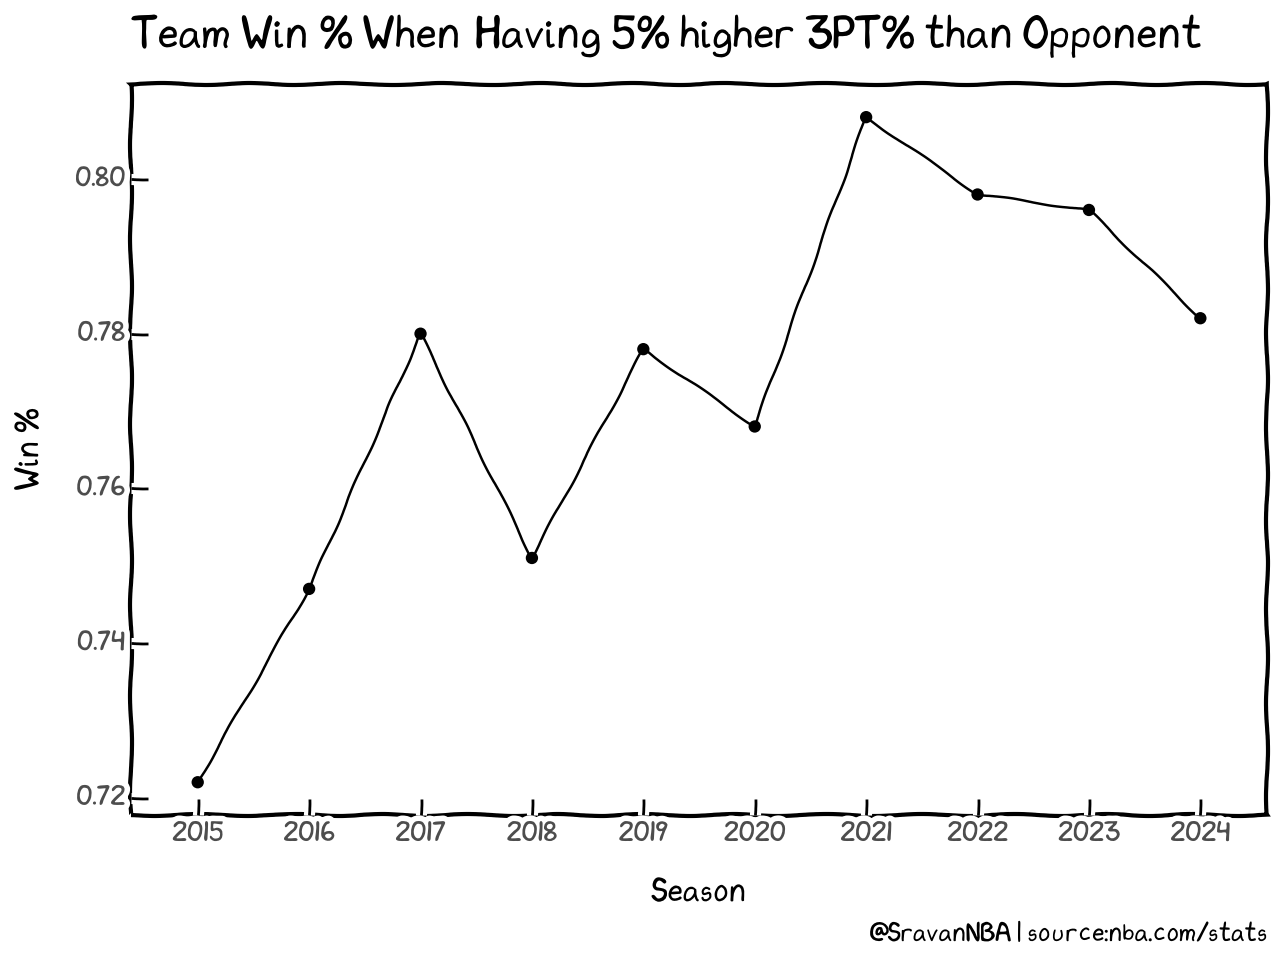

In [31]:
p = (
    ggplot(df_pw)
    + aes(x="Season", y= "Win_PCT")
    + geom_line(group=1)
    + geom_point()
    + labs(
            title= "Team Win % When Having 5% higher 3PT% than Opponent",
            caption="@SravanNBA | source:nba.com/stats",
            y = "Win %",
        )
    + theme_idv
    + theme(plot_title=element_text(face="bold", size=15))
)
p.draw()

Now, lets format the Y axis to show data in percentage instead of fraction

In [32]:
from mizani.formatters import percent_format
from plotnine import scale_y_continuous

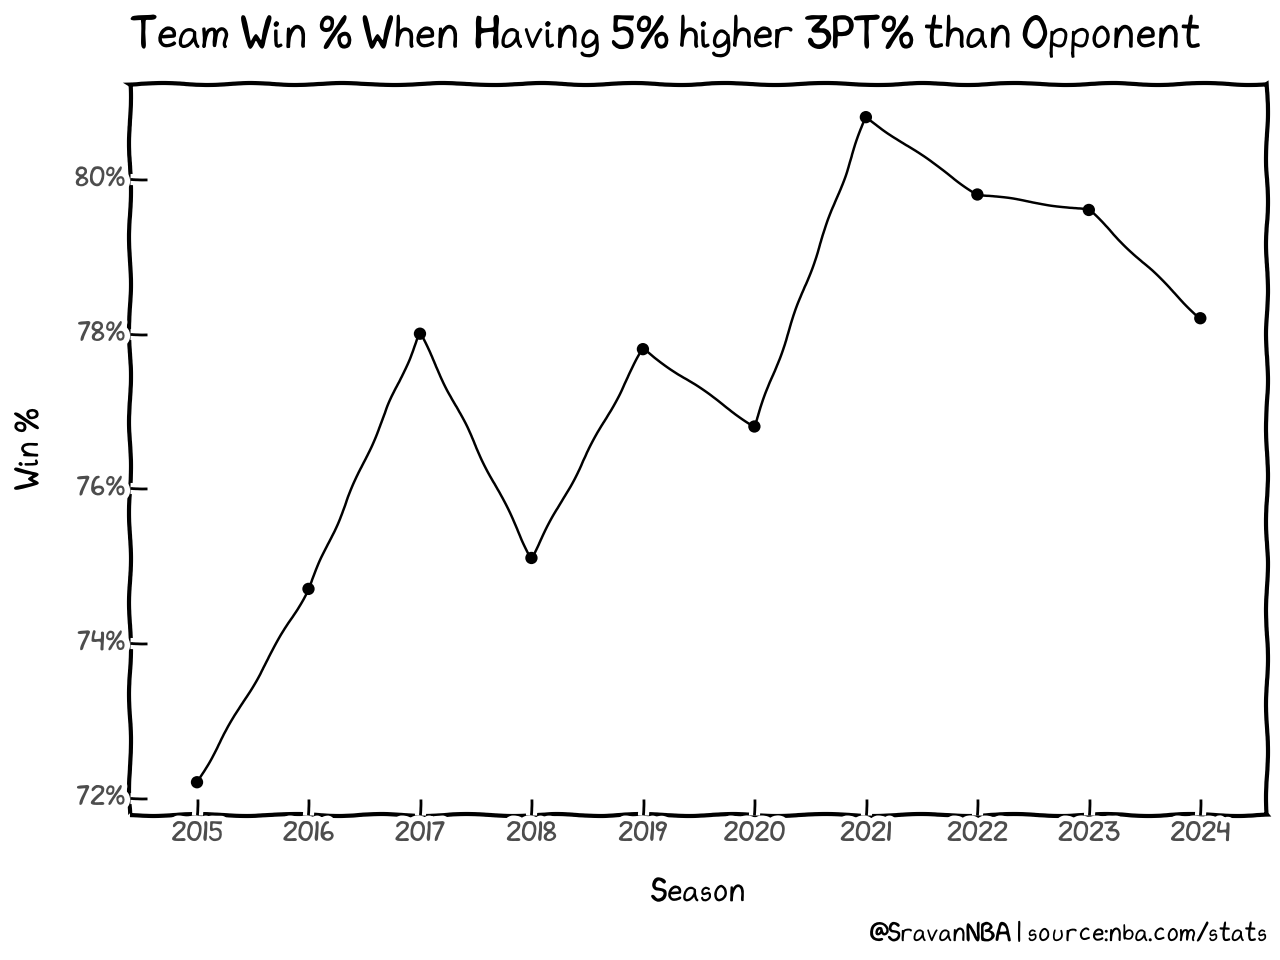

In [33]:
p = (
    ggplot(df_pw)
    + aes(x="Season", y= "Win_PCT")
    + geom_line(group=1)
    + geom_point()
    # Change Y scale to percent
    + scale_y_continuous(labels=percent_format())
    + labs(
            title= "Team Win % When Having 5% higher 3PT% than Opponent",
            caption="@SravanNBA | source:nba.com/stats",
            y = "Win %",
        )
    + theme_idv
    + theme(plot_title=element_text(face="bold", size=15))
)
p.draw()

Finally you can save the figure using the `save` command

In [34]:
p.save("FG3PCT_Wins_seasons.png", width=6.2, height=4.8, dpi=300)

c:\Users\pansr\AppData\Local\pypoetry\Cache\virtualenvs\nba-tutorials-YiaCgrin-py3.11\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 6.2 x 4.8 in image.
c:\Users\pansr\AppData\Local\pypoetry\Cache\virtualenvs\nba-tutorials-YiaCgrin-py3.11\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: FG3PCT_Wins_seasons.png
